# Classify Palm, Banana and a cat
Author: Shashank K Holla, 1Rv17EC139 shashankholla@outlook.in

This model below is a 3 class image classifier built to classify between a cat, banana and a hand. The model is derived from the popular VGG16 architecture but has been optimized to improve accuracy in thsi case.



Using the keras library with Tensorflow backend.
Make sure to use the same versions to prevent problems

In [48]:
# Data Augmentation and classes
from keras.preprocessing.image import ImageDataGenerator

# NN Libraries
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.optimizers import Adam

# Visualisation
from keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt

# Other
import math
import os




In [50]:
print("Tensorflow:" + tf.__version__)
print("Keras:" + keras.__version__)

Tensorflow:2.2.0
Keras2.3.0-tf


In [55]:
# Paths
train_data_dir = "../input/bananacathand-40n10/Dataset/train/"
validation_data_dir = "../input/bananacathand-40n10/Dataset/valid/"
test_data_dir = "../input/bananacathand-40n10/Dataset/test/"




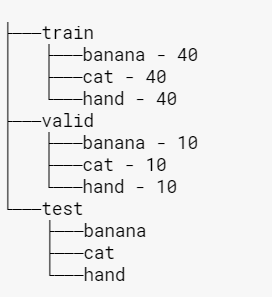

In [6]:

_inputSize      = (224,224)
_trainBatchSize = 32
_validBatchSize = 32

# Image Augmentation. Artifically generate different looking samples from the given samples

_rescaler           = 1. / 255
_shearRange         = 0.2
_zoomRange         = 0.15
_rotationRange      = 45
_widthShift         = 0.15
_heightShift        = 0.15
_isHorizontalFlip   = True
_isVerticalFlip     = True
_fillMode           = "nearest"
_epochs             = 100
_classes            = {0:'banana', 1:'cat', 2:'hand'}

_bestSaveModelName  = "best.h5"
_learningRate       = 0.0001

train_batches = ImageDataGenerator( rescale=_rescaler ,
                                    shear_range=_shearRange,
                                    zoom_range=_zoomRange,
                                    rotation_range=_rotationRange, 
                                    width_shift_range=_widthShift, 
                                    height_shift_range=_heightShift,
                                    horizontal_flip=_isHorizontalFlip,
                                    vertical_flip=_isVerticalFlip,
                                    fill_mode=_fillMode).flow_from_directory(
                                    train_data_dir, 
                                    target_size =_inputSize, 
                                    batch_size  =_trainBatchSize)
valid_batches = ImageDataGenerator( rescale=_rescaler ,
                                    shear_range=_shearRange,
                                    zoom_range=_zoomRange,
                                    rotation_range=_rotationRange, 
                                    width_shift_range=_widthShift, 
                                    height_shift_range=_heightShift,
                                    horizontal_flip=_isHorizontalFlip,
                                    vertical_flip=_isVerticalFlip,
                                    fill_mode=_fillMode).flow_from_directory(
                                    validation_data_dir, 
                                    target_size =_inputSize, 
                                    batch_size  =_trainBatchSize)


Found 120 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


### Visualisation of Data
The dataset has been taken from 4 places and judged to include a variety of photos.
1. Collection from people for hands (online data set was mostly fair hands with white background which might not work well if used to predict unprocessed images)
2. Most of the images scrapped from google images for educational purpose. 
3. Kaggle Fruits Dataset - https://www.kaggle.com/moltean/fruits?
4**. Kaggle Cats And Dogs Dataset - https://www.kaggle.com/c/dogs-vs-cats

In [52]:
 
filesPerRow = 10

 

def printDataset(p):
    files = os.listdir(p)
    noOfCols = filesPerRow
    noOfRow = int(len(files) / noOfCols)

    # Generate the subplots
    fig, axs = plt.subplots(noOfRow, noOfCols)
    fig.set_size_inches(10, 10, forward=True)

    # Map each file to subplot
    for i in range(0, len(files)):
      file_name = files[i]
      image = Image.open(f'{p}/{file_name}')
      row = math.floor(i / filesPerRow)
      col = i % filesPerRow
      axs[row, col].imshow(image)
      axs[row, col].axis('off')
    
    plt.show()
    


Dataset is comprised of training data of 40 images of each class, and 10 images for validation of each class


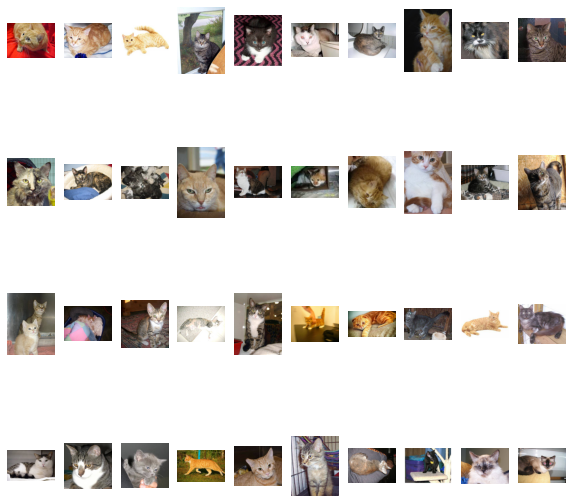

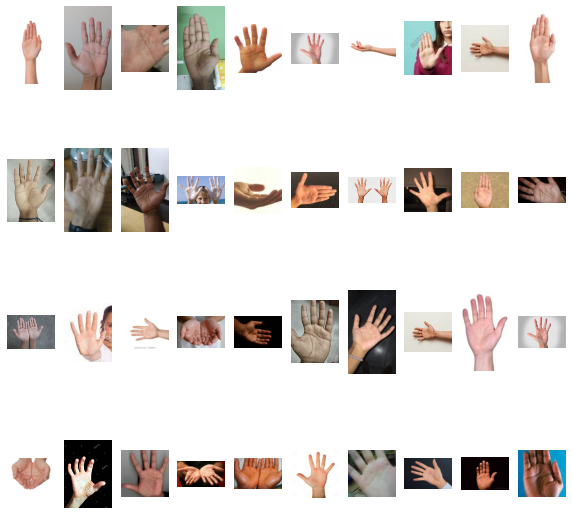

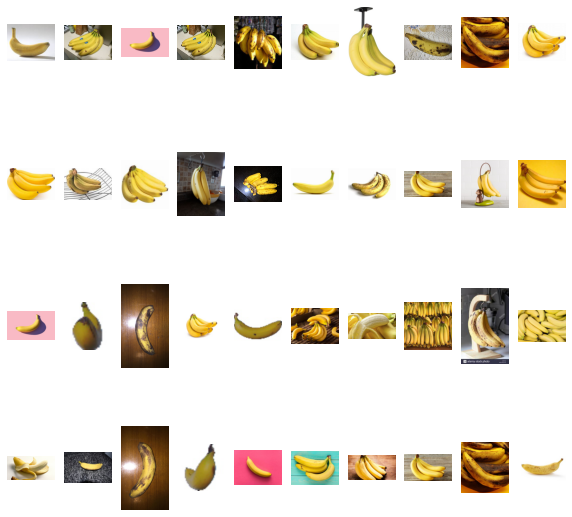

In [6]:
printDataset(train_data_dir+ "cat")
printDataset(train_data_dir+ "hand")
printDataset(train_data_dir+ "banana")

Data Augmentation is used to generate more samples from the existing set of samples by using few image processing techniques to stretch, zoom, flip and scale images. This helps the model generalise better by giving more data when dataset is limited.

And for validation 10 images per class

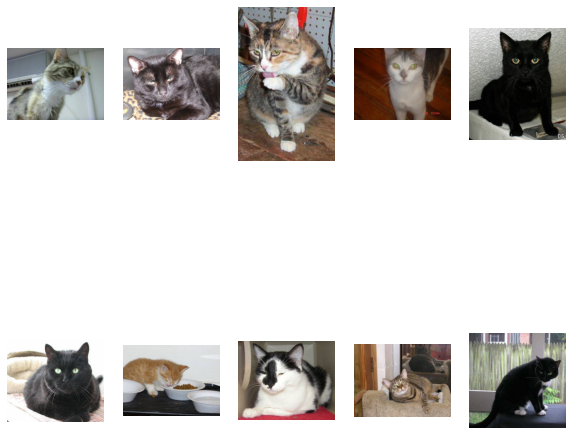

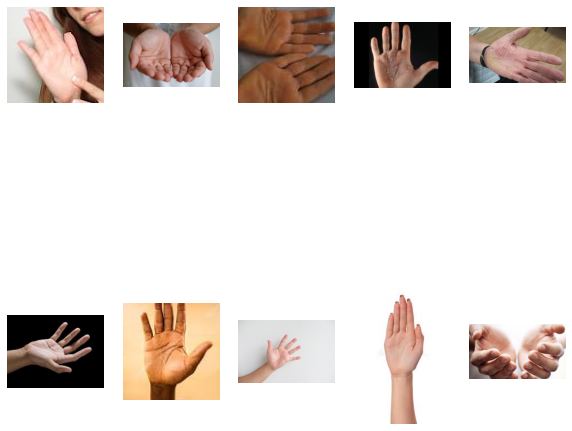

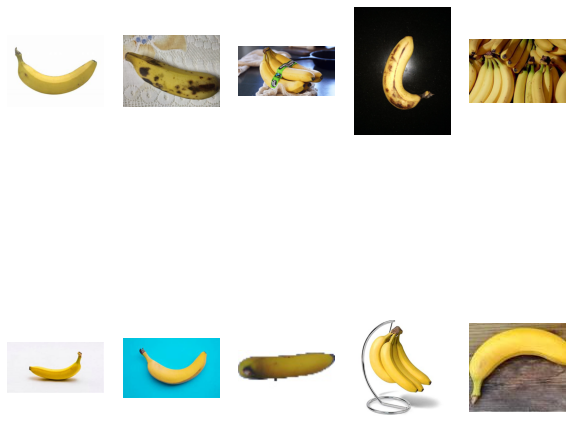

In [57]:
 
filesPerRow = 5

 

def printDataset2(p):
    files = os.listdir(p)
    noOfCols = filesPerRow
    noOfRow = int(len(files) / noOfCols)

    # Generate the subplots
    fig, axs = plt.subplots(noOfRow, noOfCols)
    fig.set_size_inches(10, 10, forward=True)

    # Map each file to subplot
    for i in range(0, len(files)):
      file_name = files[i]
      image = Image.open(f'{p}/{file_name}')
      row = math.floor(i / filesPerRow)
      col = i % filesPerRow
      axs[row, col].imshow(image)
      axs[row, col].axis('off')
    
    plt.show()
    

printDataset2(validation_data_dir+ "cat")
printDataset2(validation_data_dir+ "hand")
printDataset2(validation_data_dir+ "banana")

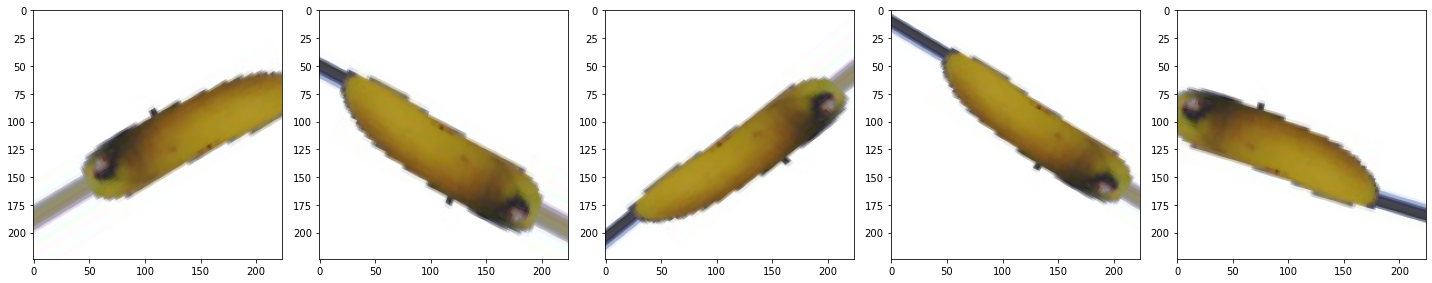

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_batches[0][0][1] for i in range(5)]
plotImages(augmented_images)



This model is a inspired from the famous VGG16 model but has been modified to reduce the layers for this application. It has an input layer of (224,224,3) with 64 output filters followed by another layer with 64 filters and "same" padding meaning the output is the same dimension as input. It is followed by a max pooling layer with stride length of (2,2). This is followed by 3 sets of similar layers with increasing number of filters to capture smaller features. Two more convolutional Dense layers with 2048 units each and ends with a 3 unit Dense layer to get the 3 classes required. 

In [14]:
model = tf.keras.Sequential()

model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=2048,activation="relu"))
model.add(Dense(units=2048,activation="relu"))
model.add(Dense(units=3, activation="softmax"))


A visualization of the model.

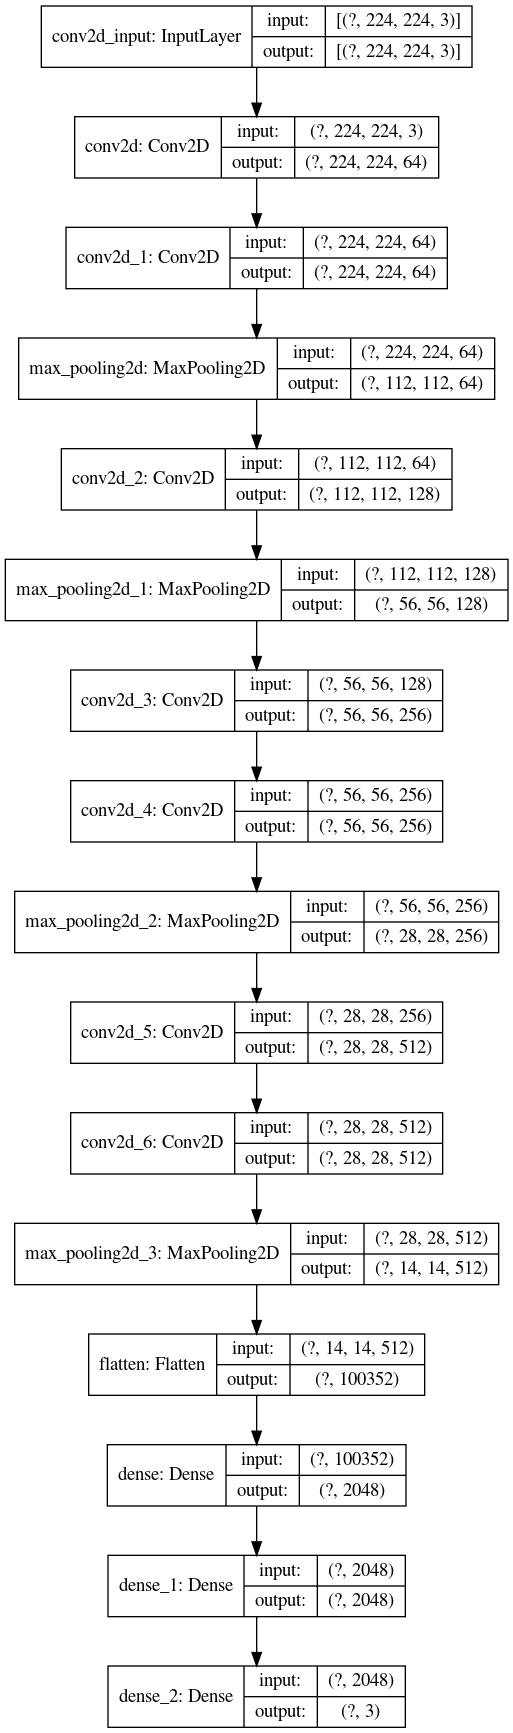

In [10]:

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Adam optimizer is used after very poor results after using SGD which gives erratic accuracy changes.
A ModelCheckPoint call back is used to save the best model based on minimum Validation lose

In [ ]:
## Getting poor results with SGD. Switching back to Adam.


#opt = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
#model.compile(loss="categorical_crossentropy",optimizer=opt,metrics=["accuracy"])
#model.fit_generator(train_batches, steps_per_epoch=16, validation_data=valid_batches, validation_steps=4, epochs=10, verbose=1)

In [15]:
opt = tf.keras.optimizers.Adam(lr=_learningRate)

mcp_save =  tf.keras.callbacks.ModelCheckpoint(_bestSaveModelName, save_best_only=True, monitor='val_loss', mode='min')

model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
history = model.fit_generator(train_batches,  validation_data=valid_batches, epochs=_epochs, verbose=1, callbacks=[mcp_save])



Epoch 1/100
4/4 [==============================] - 22s 6s/step - loss: 1.1264 - accuracy: 0.2750 - val_loss: 1.0937 - val_accuracy: 0.3333
Epoch 2/100
4/4 [==============================] - 34s 8s/step - loss: 1.0876 - accuracy: 0.4333 - val_loss: 1.0758 - val_accuracy: 0.3333
Epoch 3/100
4/4 [==============================] - 38s 9s/step - loss: 1.0315 - accuracy: 0.4250 - val_loss: 1.0096 - val_accuracy: 0.5333
Epoch 4/100
4/4 [==============================] - 4s 932ms/step - loss: 0.9610 - accuracy: 0.5500 - val_loss: 1.1263 - val_accuracy: 0.4000
Epoch 5/100
4/4 [==============================] - 35s 9s/step - loss: 0.9585 - accuracy: 0.4583 - val_loss: 0.8561 - val_accuracy: 0.6333
Epoch 6/100
4/4 [==============================] - 39s 10s/step - loss: 0.8255 - accuracy: 0.6500 - val_loss: 0.7784 - val_accuracy: 0.6333
Epoch 7/100
4/4 [==============================] - 39s 10s/step - loss: 0.7629 - accuracy: 0.6250 - val_loss: 0.6698 - val_accuracy: 0.7000
Epoch 8/100
4/4 [======

4/4 [==============================] - 4s 952ms/step - loss: 0.1771 - accuracy: 0.9333 - val_loss: 0.3573 - val_accuracy: 0.9333
Epoch 60/100
4/4 [==============================] - 4s 888ms/step - loss: 0.1630 - accuracy: 0.9333 - val_loss: 0.3929 - val_accuracy: 0.9000
Epoch 61/100
4/4 [==============================] - 3s 847ms/step - loss: 0.1264 - accuracy: 0.9417 - val_loss: 0.4938 - val_accuracy: 0.9000
Epoch 62/100
4/4 [==============================] - 3s 872ms/step - loss: 0.1140 - accuracy: 0.9583 - val_loss: 0.6114 - val_accuracy: 0.9000
Epoch 63/100
4/4 [==============================] - 3s 783ms/step - loss: 0.1154 - accuracy: 0.9333 - val_loss: 1.2162 - val_accuracy: 0.9000
Epoch 64/100
4/4 [==============================] - 3s 844ms/step - loss: 0.1063 - accuracy: 0.9583 - val_loss: 1.0034 - val_accuracy: 0.9000
Epoch 65/100
4/4 [==============================] - 3s 839ms/step - loss: 0.0820 - accuracy: 0.9750 - val_loss: 1.0575 - val_accuracy: 0.9000
Epoch 66/100
4/4 [=

A very erratic validation loss can be seen but the accuracy climbs up steadily and plateus around 95%

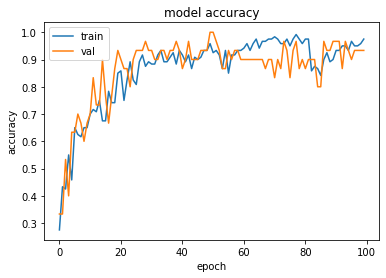

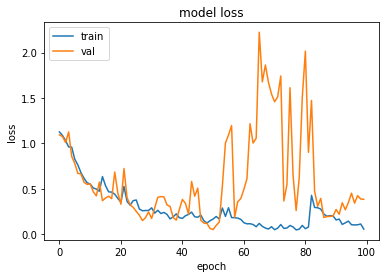

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Check Accuracy against 30 test images

In [17]:
test_batches = ImageDataGenerator(rescale=1. / 255,
    shear_range=0.5,
    zoom_range=0.5,
    rotation_range=45, 
    width_shift_range=.15, 
    height_shift_range=.15,
    horizontal_flip=True,
    vertical_flip=True).flow_from_directory(test_data_dir, target_size=(224,224), batch_size=10)
d = model.evaluate_generator(test_batches)
print("Loss: {} and Accuracy: {:02}".format(d[0],d[1]*100))

Found 29 images belonging to 3 classes.
Loss: 0.4342779219150543 and Accuracy: 86.20689511299133


In [30]:
tr = model.evaluate_generator(train_batches)
v = model.evaluate_generator(valid_batches)
test = model.evaluate_generator(test_batches)

print("Train Loss: {} and Accuracy: {:02}".format(tr[0],tr[1]*100))
print("Valid Loss: {} and Accuracy: {:02}".format(v[0],v[1]*100))
print("Test Loss: {} and Accuracy: {:02}".format(test[0],test[1]*100))

Train Loss: 0.06878527253866196 and Accuracy: 96.66666388511658
Valid Loss: 0.4679800570011139 and Accuracy: 93.33333373069763
Test Loss: 0.5713502168655396 and Accuracy: 75.86206793785095


Poor test accuracy. Over fitting could be a problem. Too complex layers might result in overfitting

In [ ]:
model.save("VGGbananaM1.h5")

Checking for random image to test

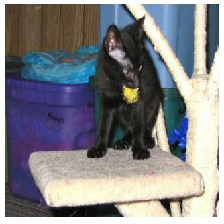

[[2.2680389e-03 9.9996552e+01 1.1849966e-03]]
{'banana': 0, 'cat': 1, 'hand': 2}
cat


In [63]:

from keras.preprocessing import image
from IPython.display import Image 


import numpy as np
img = image.load_img('../input/bananacathand/Dataset/train/cat/cat.23.jpg', target_size=(224,224))
display(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x*(1./255)
images = np.vstack([x])

classes = model.predict(images)
print(classes*100)
print(valid_batches.class_indices)
print(_classes[np.argmax(classes)])

In [ ]:
#For saving the model 


# print(tf.__version__)
# from keras.models import model_from_json
# loaded_model = tf.keras.models.load_model("best.h5")
# json_model = loaded_model.to_json()
# with open('BananaWeights_model.json', 'w') as json_file:
#     json_file.write(json_model)
# #saving the weights of the model
# loaded_model.save_weights('BananaWeights.h5')




In [ ]:
# json_file = open('BananaWeights_model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("BananaWeights.h5")
# loaded_model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
# loaded_model.evaluate_generator(train_batches)

Now I test with the test set that is out of the 150 training images to get an idea

In [36]:
print(model)
from keras.preprocessing import image
import numpy as np

for c in os.listdir("../input/bananacathand/Dataset/test/cat"):
  print(c)
  img = image.load_img("../input/bananacathand/Dataset/test/cat/" +c, target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x*(1./255)
  images = np.vstack([x])
  classes = model.predict(images)
  print(_classes[np.argmax(classes)])
  print()
 


cat.25.jpg
cat

cat.8.jpg
cat

cat.36.jpg
cat

rscat2.jpg
cat

vatx.jpg
cat

cat.17.jpg
cat

cat-banana.jpg
banana

cat.26.jpg
hand

cat.44.jpg
cat

cat.13.jpg
cat

cat.15.jpg
cat

cat.11.jpg
cat

cat.3.jpg
hand

cathand.jpg
hand



## Trying to reduce complexity to achieve faster training speed and lesser model size

I feel this model is too complex for the need. Thus need to reduce layers to improve the problem of overfitting. Trying to play around with filters

In [38]:
model2 = tf.keras.Sequential()

model2.add(Conv2D(input_shape=(224,224,3),filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


model2.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model2.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model2.add(Flatten())
model2.add(Dense(units=1024,activation="relu"))
model2.add(Dense(units=1024,activation="relu"))

model2.add(Dense(units=3, activation="softmax"))

In [39]:

_bestSaveModelName2 = "best2.h5"
opt = tf.keras.optimizers.Adam(lr=_learningRate)

mcp_save =  tf.keras.callbacks.ModelCheckpoint(_bestSaveModelName2, save_best_only=True, monitor='val_loss', mode='min')

model2.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
history = model2.fit_generator(train_batches,  validation_data=valid_batches, epochs=_epochs, verbose=1, callbacks=[mcp_save])



Epoch 1/100
4/4 [==============================] - 5s 1s/step - loss: 1.0986 - accuracy: 0.3250 - val_loss: 1.0883 - val_accuracy: 0.3333
Epoch 2/100
4/4 [==============================] - 5s 1s/step - loss: 1.0818 - accuracy: 0.3333 - val_loss: 1.0691 - val_accuracy: 0.6333
Epoch 3/100
4/4 [==============================] - 5s 1s/step - loss: 1.0674 - accuracy: 0.4917 - val_loss: 1.0414 - val_accuracy: 0.6667
Epoch 4/100
4/4 [==============================] - 5s 1s/step - loss: 0.9774 - accuracy: 0.5500 - val_loss: 0.9840 - val_accuracy: 0.6000
Epoch 5/100
4/4 [==============================] - 6s 2s/step - loss: 0.9079 - accuracy: 0.6083 - val_loss: 0.9058 - val_accuracy: 0.6333
Epoch 6/100
4/4 [==============================] - 8s 2s/step - loss: 0.8675 - accuracy: 0.5333 - val_loss: 0.7517 - val_accuracy: 0.7000
Epoch 7/100
4/4 [==============================] - 13s 3s/step - loss: 0.7699 - accuracy: 0.6083 - val_loss: 0.6746 - val_accuracy: 0.6667
Epoch 8/100
4/4 [================

4/4 [==============================] - 4s 959ms/step - loss: 0.1376 - accuracy: 0.9500 - val_loss: 0.2485 - val_accuracy: 0.9333
Epoch 60/100
4/4 [==============================] - 4s 922ms/step - loss: 0.1512 - accuracy: 0.9417 - val_loss: 0.3811 - val_accuracy: 0.9333
Epoch 61/100
4/4 [==============================] - 3s 800ms/step - loss: 0.1106 - accuracy: 0.9333 - val_loss: 0.5145 - val_accuracy: 0.9000
Epoch 62/100
4/4 [==============================] - 3s 841ms/step - loss: 0.0718 - accuracy: 0.9667 - val_loss: 0.4034 - val_accuracy: 0.9333
Epoch 63/100
4/4 [==============================] - 4s 894ms/step - loss: 0.0902 - accuracy: 0.9583 - val_loss: 0.3541 - val_accuracy: 0.9000
Epoch 64/100
4/4 [==============================] - 3s 766ms/step - loss: 0.1076 - accuracy: 0.9583 - val_loss: 0.3365 - val_accuracy: 0.9667
Epoch 65/100
4/4 [==============================] - 3s 867ms/step - loss: 0.1186 - accuracy: 0.9583 - val_loss: 0.7398 - val_accuracy: 0.8333
Epoch 66/100
4/4 [=

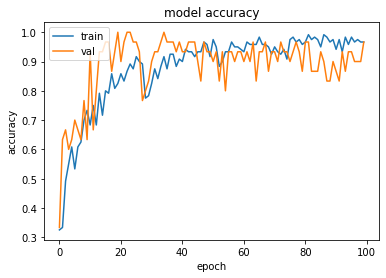

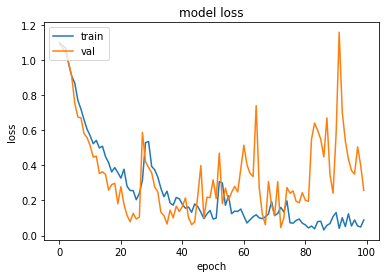

In [65]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
bestModel = tf.keras.models.load_model("best2.h5")
d = bestModel.evaluate_generator(train_batches)
print("Train: Loss: {} and Accuracy: {:02}".format(d[0],d[1]*100))

d = bestModel.evaluate_generator(valid_batches)
print("Valid: Loss: {} and Accuracy: {:02}".format(d[0],d[1]*100))

d = bestModel.evaluate_generator(test_batches)
print("Test: Loss: {} and Accuracy: {:02}".format(d[0],d[1]*100))

Train: Loss: 0.17853008210659027 and Accuracy: 93.33333373069763
Valid: Loss: 0.05634515359997749 and Accuracy: 96.66666388511658
Test: Loss: 0.713640570640564 and Accuracy: 86.20689511299133


The model is achieveing better accuracy with test data set.


References:

1.https://keras.io/api/layers/ <br>
2.https://www.kaggle.com/moltean/fruits? <br>
3.https://www.kaggle.com/c/dogs-vs-cats <br>
4.https://neurohive.io/en/popular-networks/vgg16/ <br>
5.https://www.geeksforgeeks.org/vgg-16-cnn-model/ <br>